<a href="https://colab.research.google.com/github/maggieliuzzi/reinforcement_learning/blob/master/monte_carlo/prediction/Approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Monte Carlo** | Prediction Problem | Approximation

In [0]:
from __future__ import print_function, division
from builtins import range
import matplotlib.pyplot as plt
import numpy as np
!wget "https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/rl/grid_world.py"
from grid_world import standard_grid, negative_grid
!wget "https://raw.githubusercontent.com/maggieliuzzi/reinforcement_learning/master/environments/utils.py"
from utils import print_values, print_policy

In [0]:
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
LEARNING_RATE = 0.001

In [0]:
def random_action(a):
  # choose given a with probability 0.5
  # choose some other a' != a with probability 0.5/3
  p = np.random.random()
  if p < 0.5:
    return a
  else:
    tmp = list(ALL_POSSIBLE_ACTIONS)
    tmp.remove(a)
    return np.random.choice(tmp)

In [0]:
def play_game(grid, policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this, because given our current deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s]
    a = random_action(a)
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
  # calculate the returns by working backwards from the terminal state
  G = 0
  states_and_returns = []
  first = True
  for s, r in reversed(states_and_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_and_returns.append((s, G))
    G = r + GAMMA*G
  states_and_returns.reverse() # we want it to be in order of state visited
  
  return states_and_returns

In [13]:
grid = standard_grid()

print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


In [0]:
policy = {
  (2, 0): 'U',
  (1, 0): 'U',
  (0, 0): 'R',
  (0, 1): 'R',
  (0, 2): 'R',
  (1, 2): 'U',
  (2, 1): 'L',
  (2, 2): 'U',
  (2, 3): 'L',
}

In [0]:
# initialize theta
# our model is V_hat = theta.dot(x)
# where x = [row, col, row*col, 1] - 1 for bias term
theta = np.random.randn(4) / 2
def s2x(s):
  return np.array([s[0] - 1, s[1] - 1.5, s[0]*s[1] - 3, 1])

In [0]:
# repeat until convergence
deltas = []
t = 1.0
for it in range(20000):
  if it % 100 == 0:
    t += 0.01
  alpha = LEARNING_RATE/t
  # generate an episode using pi
  biggest_change = 0
  states_and_returns = play_game(grid, policy)
  seen_states = set()
  for s, G in states_and_returns:
    # check if we have already seen s
    # called "first-visit" MC policy evaluation
    if s not in seen_states:
      old_theta = theta.copy()
      x = s2x(s)
      V_hat = theta.dot(x)
      # grad(V_hat) wrt theta = x
      theta += alpha*(G - V_hat)*x
      biggest_change = max(biggest_change, np.abs(old_theta - theta).sum())
      seen_states.add(s)
  deltas.append(biggest_change)

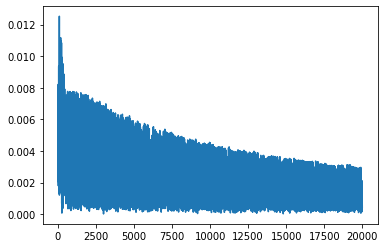

In [17]:
plt.plot(deltas)
plt.show()

In [0]:
# obtain predicted values
V = {}
states = grid.all_states()
for s in states:
  if s in grid.actions:
    V[s] = theta.dot(s2x(s))
  else:
    # terminal state or state we can't otherwise get to
    V[s] = 0

In [19]:
print("values:")
print_values(V, grid)
print("policy:")
print_policy(policy, grid)

values:
---------------------------
 0.48| 0.62| 0.76| 0.00|
---------------------------
 0.41| 0.00| 0.38| 0.00|
---------------------------
 0.33| 0.17| 0.00|-0.17|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  U  |  L  |
